In [1]:
using PyPlot, SeisPlot
using FFTW
using LinearAlgebra
using DSP, MAT
using Random
using SeisProcessing

┌ Info: Recompiling stale cache file /home/rongzhilin/.julia/compiled/v1.1/MAT/3FHIv.ji for MAT [23992714-dd62-5051-b70f-ba57cb901cac]
└ @ Base loading.jl:1184


In [2]:
include("BlendOpFreq.jl")
include("FastHankelMultply.jl")
include("Hankelization.jl")
include("Anti_Diagonal_Average.jl")
include("SeisFSSA.jl")
include("SeisMSSA.jl")
include("SeisRandomQR.jl")
include("Ricker.jl")
include("SeisLocal.jl")
include("SeisLocalPatch.jl")
include("SeisRadontimePara.jl")
include("ApplyTaper.jl")
include("SeisUnlocal.jl")

SeisUnlocal

In [4]:
file = matopen("s200_r400.mat")
data = read(file, "d"); # note that this does NOT introduce a variable ``varname`` into scope
close(file)

#D   = data[:,101:200,51:300];
D   = data;
(nt,nr,ns) = size(D)
dt = 0.004
Random.seed!(1234)
################# FOR blending_forward_adjoint2 Test [nt,nr,ns]##########################
QD0 = (norm(D))^2;

jtime = rand(ns)*0.5*nt*dt ;

b = BlendOpFreq(D,false;ns=ns,nr=nr,nt=nt,jtime=jtime)
D1 = BlendOpFreq(b,true; ns=ns,nr=nr,nt=nt,jtime=jtime)


501×400×200 Array{Float64,3}:
[:, :, 1] =
  5.73234e-9   5.73234e-9   5.73234e-9  …  -4.85085e-10  -3.6861e-10 
 -5.77033e-9  -5.77033e-9  -5.77033e-9      5.01612e-10   3.69369e-10
  5.80862e-9   5.80862e-9   5.80862e-9     -5.18152e-10  -3.70137e-10
 -5.84721e-9  -5.84721e-9  -5.84721e-9      5.34701e-10   3.70911e-10
  5.88611e-9   5.88611e-9   5.88611e-9     -5.51263e-10  -3.71693e-10
 -5.92531e-9  -5.92531e-9  -5.92531e-9  …   5.67835e-10   3.72482e-10
  5.96483e-9   5.96483e-9   5.96483e-9     -5.84419e-10  -3.73278e-10
 -6.00467e-9  -6.00467e-9  -6.00467e-9      6.01016e-10   3.74082e-10
  6.04483e-9   6.04483e-9   6.04483e-9     -6.17625e-10  -3.74894e-10
 -6.08532e-9  -6.08532e-9  -6.08532e-9      6.34247e-10   3.75712e-10
  6.12614e-9   6.12614e-9   6.12614e-9  …  -6.50882e-10  -3.76538e-10
 -6.16731e-9  -6.16731e-9  -6.16731e-9      6.67531e-10   3.77372e-10
  6.20881e-9   6.20881e-9   6.20881e-9     -6.84194e-10  -3.78213e-10
  ⋮                                     ⋱       

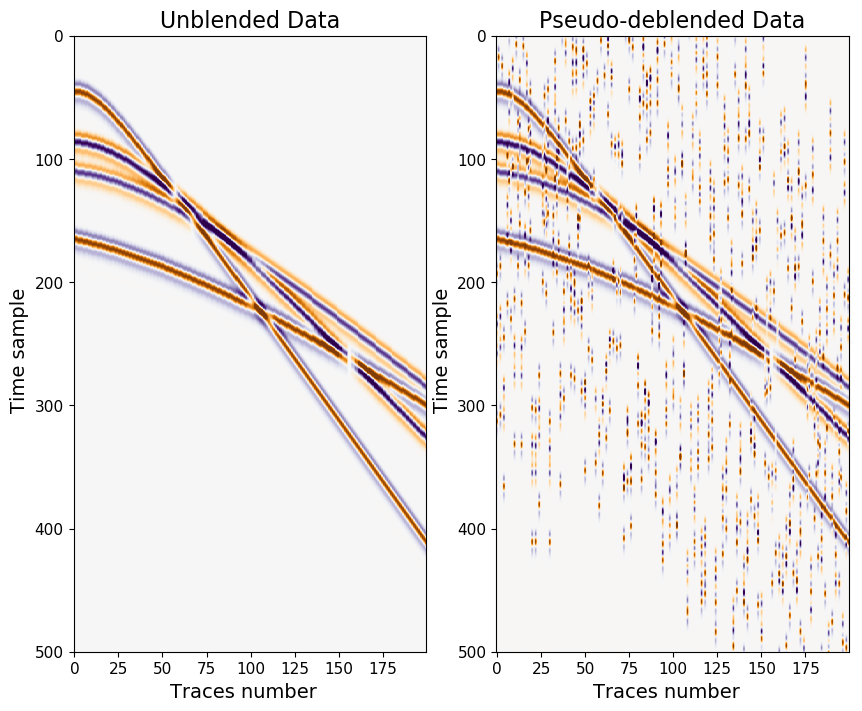

PyObject <matplotlib.image.AxesImage object at 0x7fa6b494c810>

In [6]:
close("all")
vm=1
figure(1, figsize=(10, 8))
subplot(121);SeisPlotTX(D[:,5,:], title="Unblended Data", fignum=1, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)
subplot(122);SeisPlotTX(D1[:,5,:], title="Pseudo-deblended Data", fignum=1, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)


In [9]:
param1 = Dict(:order=>"3D", :dt=>0.004,:it_WL=>100,:it_WO=>20,:dx1=>1,:ix1_WL=>50,:ix1_WO=>20,:x1min=>1,:x1max=>nr);

param2 = Dict(:dx2=>1,:ix2_WL=>50,:ix2_WO=>20,:x2min=>1,:x2max=>ns);


In [8]:
ns

200

In [10]:
lamda = 0.5
rk    = 6

D3    = copy(D1);
D4    = copy(D1);
@time for i = 1:20
    global D3
    b3 = BlendOpFreq(D3,false;ns=ns,nr=nr,nt=nt,jtime=jtime)
    Dtemp3 = BlendOpFreq(b3-b,true; ns=ns,nr=nr,nt=nt,jtime=jtime)
    z3 = D3 - lamda.*Dtemp3;

    param1 = Dict(:order=>"3D", :dt=>0.004,:it_WL=>100,:it_WO=>20,:dx1=>1,:ix1_WL=>50,:ix1_WO=>20,:x1min=>1,:x1max=>nr);

    param2 = Dict(:dx2=>1,:ix2_WL=>50,:ix2_WO=>20,:x2min=>1,:x2max=>ns);
    (zout,Minval,Maxval) = SeisLocal(z3; param1...,param2...)
    pzout = zeros(eltype(zout),size(zout))
    if rem(i,5)==0
        global rk
        rk = rk+1
    end
    for ip = 1 : size(zout,ndims(zout))
        # pzout[:,:,:,ip] = SeisFSSA(zout[:,:,:,ip],rk,0.004,1.0,125.0; order="3D")
        pzout[:,:,:,ip] = SeisRandomQR(zout[:,:,:,ip], rk; dt=0.004, flow=1.0, fhigh=125.0, order="3D")
    end

    # D3 = SeisFSSA(z3,rk,0.004,1.0,125.0; or der="3D")

    D3 = SeisUnlocal(pzout,Minval,Maxval,nt; param1...,param2...)

    b3 = BlendOpFreq(D3,false;ns=ns,nr=nr,nt=nt,jtime=jtime)
    e3 = b - b3
    error3 = dot(vec(e3), vec(e3));
    println(error3)
end
QD3 = (norm(D-D3))^2
QS3 = 10*log10(QD0/QD3)
println(QS3)

Number of patches= 24


DimensionMismatch: DimensionMismatch("dimensions must match")

In [11]:
lamda = 0.5
rk    = 6

D3    = copy(D1);
D4    = copy(D1);

@time for i = 1:20
    global D4
    b4 = BlendOpFreq(D4,false;ns=ns,nr=nr,nt=nt,jtime=jtime)
    Dtemp4 = BlendOpFreq(b4-b,true; ns=ns,nr=nr,nt=nt,jtime=jtime)
    z4 = D4 - lamda.*Dtemp4;

    param1 = Dict(:order=>"3D", :dt=>0.004,:it_WL=>100,:it_WO=>20,:dx1=>1,:ix1_WL=>50,:ix1_WO=>20,:x1min=>1,:x1max=>nr);

    param2 = Dict(:dx2=>1,:ix2_WL=>50,:ix2_WO=>20,:x2min=>1,:x2max=>ns);
    (zout4,Minval4,Maxval4) = SeisLocal(z4; param1...,param2...)
    pzout4 = zeros(eltype(zout4),size(zout4))
    if rem(i,5)==0
        global rk
        rk = rk+1
    end
    for ip = 1 : size(zout4,ndims(zout4))
        pzout4[:,:,:,ip] = SeisFSSA(zout4[:,:,:,ip],rk,0.004,1.0,125.0; order="3D")
        # pzout[:,:,:,ip] = SeisRandomQR(zout[:,:,:,ip], rk; dt=0.004, flow=1.0, fhigh=125.0, order="3D")
    end

    # D3 = SeisFSSA(z3,rk,0.004,1.0,125.0; or der="3D")

    D4 = SeisUnlocal(pzout4,Minval4,Maxval4,nt; param1...,param2...)

    b4 = BlendOpFreq(D4,false;ns=ns,nr=nr,nt=nt,jtime=jtime)
    e4 = b - b4
    error4 = dot(vec(e4), vec(e4));
    println(error4)
end
QD4 = (norm(D-D4))^2
QS4 = 10*log10(QD0/QD4)
println(QS4)


Number of patches= 300
140941.44453161914
Number of patches= 300
89595.74525936543
Number of patches= 300
60785.84504904177
Number of patches= 300
44619.14988701722
Number of patches= 300
32857.011935962946
Number of patches= 300
28015.13582530443
Number of patches= 300
25051.677003573146
Number of patches= 300
23140.40401774385
Number of patches= 300
21860.126893469707
Number of patches= 300
19737.38482886401
Number of patches= 300
19062.60195188137
Number of patches= 300
18638.307480381733
Number of patches= 300
18352.771603119323
Number of patches= 300
18150.951874867373
Number of patches= 300
17406.30571454813
Number of patches= 300
17226.25484060085
Number of patches= 300
17127.871278322717
Number of patches= 300
17068.36080469576
Number of patches= 300
17026.14713583602
Number of patches= 300
16202.02891274278
6928.625865 seconds (16.98 G allocations: 8.215 TiB, 14.76% gc time)
18.709021599684274


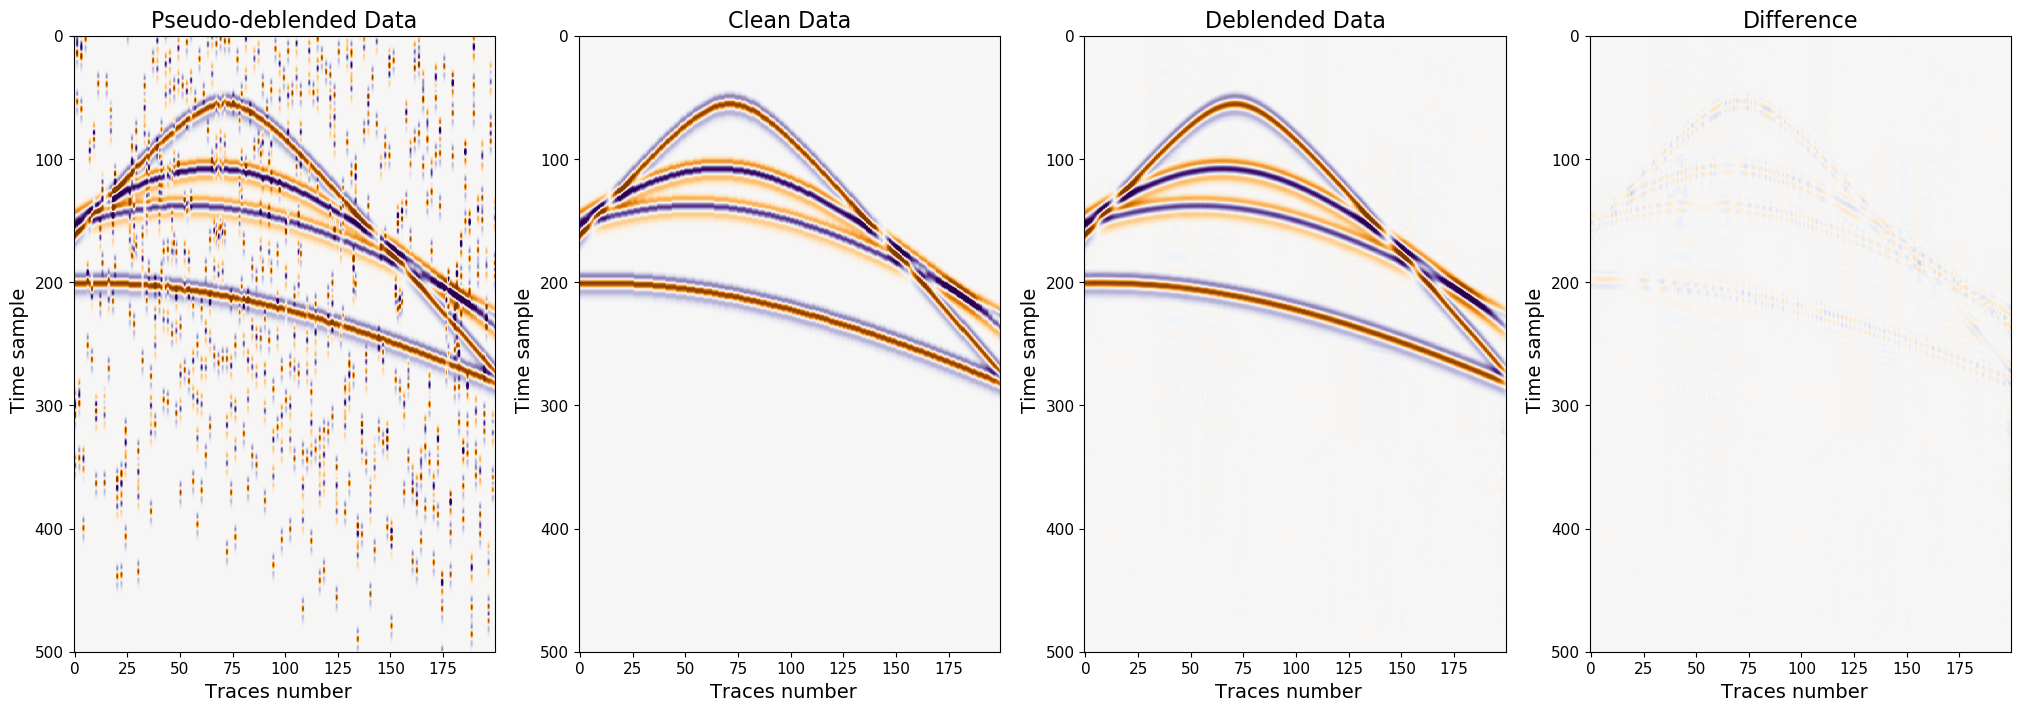

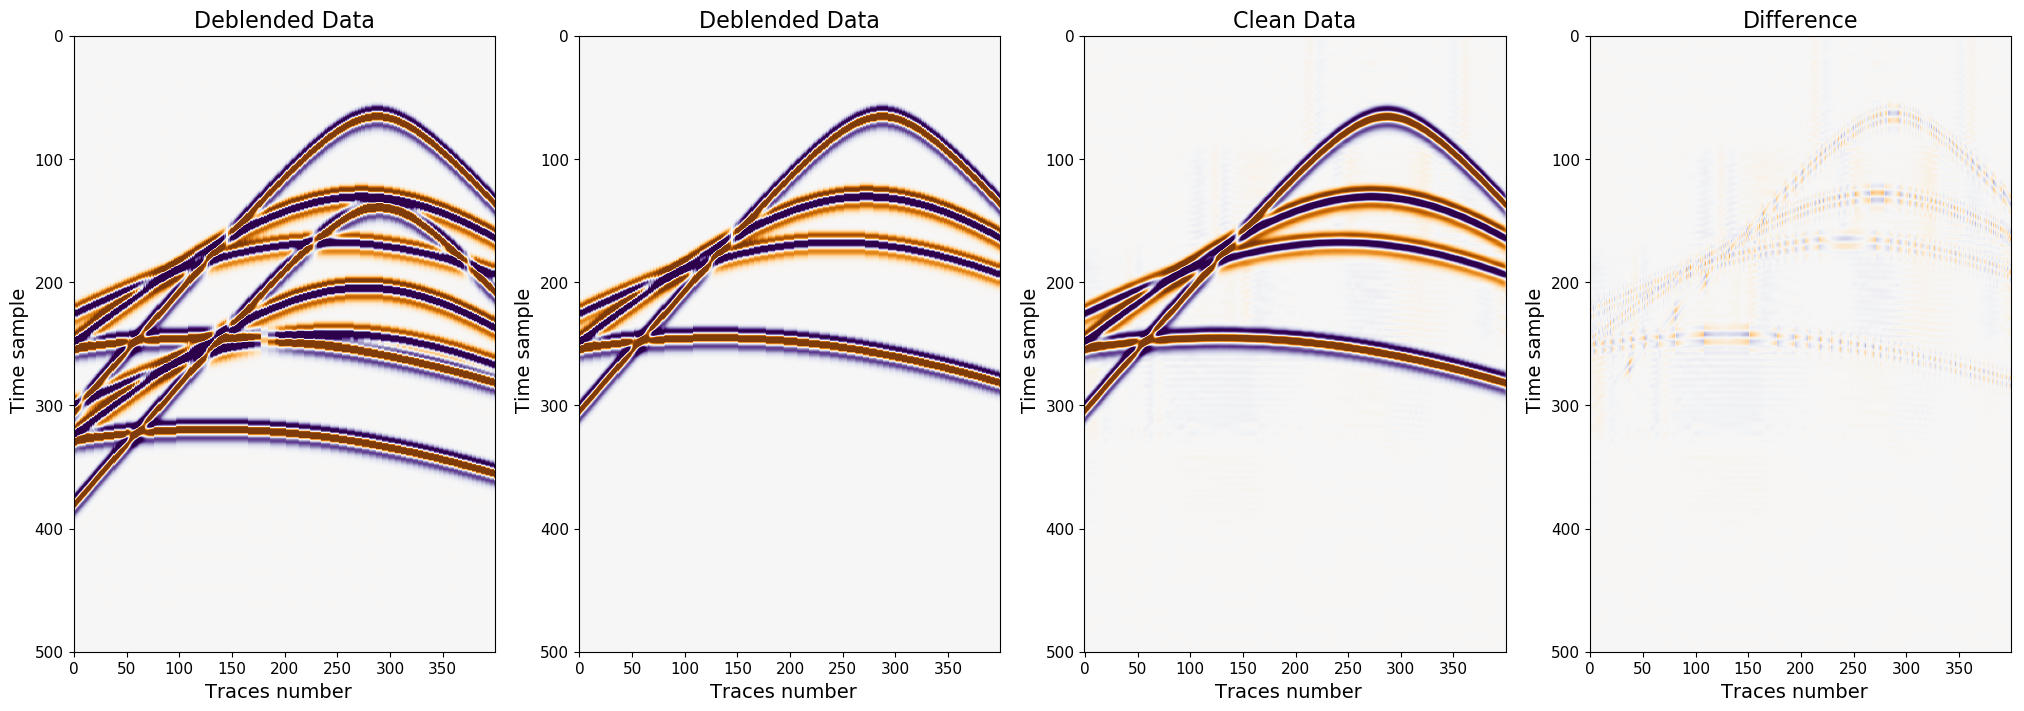

PyObject <matplotlib.image.AxesImage object at 0x7fa69f58ac50>

In [17]:
# for Common receiver gather

figure(2, figsize=(25, 8))
vm = 1;
k = 145;
subplot(141);SeisPlotTX(D1[:,k,:], title="Pseudo-deblended Data", fignum=2, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)
subplot(142);SeisPlotTX(D[:,k,:],  title="Clean Data", fignum=2, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)
subplot(143);SeisPlotTX(D4[:,k,:], title="Deblended Data",     fignum=2, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)
subplot(144);SeisPlotTX(D4[:,k,:]-D[:,k,:], title="Difference",fignum=2, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)

# for Common shot gather 

figure(3, figsize=(25, 8))
vm=0.5;
subplot(141);SeisPlotTX(D1[:,:,k], title="Deblended Data", fignum=3, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)
subplot(142);SeisPlotTX(D[:,:,k], title="Deblended Data", fignum=3, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)
subplot(143);SeisPlotTX(D4[:,:,k],  title="Clean Data", fignum=3, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)
subplot(144);SeisPlotTX(D4[:,:,k]-D[:,:,k], title="Difference", fignum=3, xlabel="Traces number",ylabel="Time sample",style="color",vmin=-vm,vmax=vm)


In [19]:
file = matopen("s200_r400debl.mat", "w")
write(file, "D4", D4)
close(file)

HDF5-DIAG: Error detected in HDF5 (1.10.4) thread 0:
  #000: H5F.c line 444 in H5Fcreate(): unable to create file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1364 in H5F__create(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #002: H5Fint.c line 1579 in H5F_open(): unable to truncate a file which is already open
    major: File accessibilty
    minor: Unable to open file


ErrorException: Error creating file s200_r400debl.mat

In [25]:
path2 = "/home/rongzhilin/rongzhi/Robust_Deblending/Low-Rank/s200_r400debl.bin"  # path to the file
out2 =  open(path2,"w")
# write(out,nt)
# write(out,nr)
# write(out,ns)
write(out2,vec(D4))
close(out2)

In [26]:
path2 = "/home/rongzhilin/rongzhi/Robust_Deblending/Low-Rank/blend.bin"  # path to the file
out2 =  open(path2,"w")
# write(out,nt)
# write(out,nr)
# write(out,ns)
write(out2,vec(D1))
close(out2)

In [24]:
501*400*200

40080000